# Table of contents

**1. Installation & setup**
   - Install bombcell package
   - Import libraries and set up paths
   - Configure parameters for both quality metrics and ephys properties

**2. Quality metrics analysis**
   - Run bombcell quality control pipeline
   - Classify units (good/MUA/noise/non-somatic)
   - Explore quality metrics results
   - Use interactive GUI for manual validation
   - Fine-tune classification parameters

**3. Ephys properties & cell classification** 
   - Compute electrophysiological properties (firing patterns, waveform features, etc.)
   - Classify cell types (cortical: pyramidal/interneurons, striatal: MSN/FSI/UIN)
   - Generate classification plots and results

---

# 1. Installation & setup

#### Install bombcell

To install the latest stable version:
```bash
conda create -n bombcell python=3.11
conda activate bombcell
pip install uv
uv pip install bombcell # you could do `pip install .`, but uv is much quicker!
```
To install the dev version (with the latest updates): 
```bash
conda create -n bombcell python=3.11
conda activate bombcell
git clone https://github.com/Julie-Fabre/bombcell.git
cd bombcell/pyBombCell
pip install uv
uv pip install -e .
```

#### Import libraries

In [1]:
import os, sys
from pathlib import Path
from pprint import pprint 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

import bombcell as bc

✅ ipywidgets available - interactive GUI ready


In [2]:
# Optional

# # Add bombcell to Python path if NOT installed with pip
# # If notebook is running in bombcell repo:
# demo_dir = Path(os.getcwd())
# pyBombCell_dir = demo_dir.parent
# # Else:
# # pyBombCell_dir = "path/to/bombcell/repository/root"
# sys.path.append(str(pyBombCell_dir))

#### Define paths

In [3]:
# Replace with your kilosort directory
ks_dir = "Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4"

# Set bombcell's output directory
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4


# Section 1: Quality Metrics

In [4]:
## Provide raw and meta files
## Leave 'None' if no raw data. Ideally, your raw data is common-average-referenced and
# the channels are temporally aligned to each other (this can be done with CatGT)
raw_file_path =  None # "/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/20250411_4423_C1_g0_tcat.imec0.ap.bin" #None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0_bc_decompressed.imec0.ap.bin" # ks_dir
meta_file_path = None # "/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/20250411_4423_C1_g0_tcat.imec0.ap.meta" #None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0_bc_decompressed.imec0.ap.bin"None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0.imec0.ap.meta"
## Get default parameters - we will see later in the notebook how to assess and fine-tune these
param = bc.get_default_parameters(ks_dir, 
                                  raw_file=raw_file_path,
                                  meta_file=meta_file_path,
                                  kilosort_version=4)

print("Bombcell parameters:")
pprint(param)

Bombcell parameters:
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendForUnitMatch': False,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 3.4e-05,
 'ephysKilosortPath': 'Y:\\SGL_DATA_drive\\wmm001_250705_rec_d12\\catgt_wmm001_250705_rec_d12_g0\\wmm001_250705_rec_d12_g0_imec0\\imec0_ks4',
 'ephys_meta_file': None,
 'ephys_sample_rate': 30000,
 'extractRaw': True,
 'gain_to_uV': None,
 'hillOrLlobetMethod': True,
 'isoDmin': 20,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 'maxScndPeakToTroughRatio_noise': 0.8,
 'maxSpatialDecaySlopeExp': 0.1,
 'maxWvBaselineFraction': 0.3,
 'maxWvDuration': 1150,
 'minAmplitude': 40,
 'minNumSpikes': 300,
 'minPresenceRatio': 0.7,
 'mi

##### Optionally, customize parameters (more on this later, below)

In [5]:
# you might to change:

# 1. classification thresholds like: 
# param["maxRPVviolations"] = 0.1


#  2. or which quality metrics are computed (by default these are not): 
param["computeDistanceMetrics"] = 0
param["computeDrift"] = 0
param["splitGoodAndMua_NonSomatic"] = 0


#  3. how quality metricsa are calculated:
# a. how refractory period window is defined
param["tauR_valuesMin"]= 0.5 / 1000  # minumum refractory period time (s), usually 0.002 s
param["tauR_valuesMax"]= 5 / 1000  # maximum refractory period time (s)
param["tauR_valuesStep"]= 0.5 / 1000  # if tauR_valuesMin and tauR_valuesMax are different, bombcell 
# will calculate refractory period violations from param["tauR_valuesMin"] to param["tauR_valuesMax"] param["tauR_valuesStep"] 
# bins and determine the option window for each unit before calculating the violations. 
        # tauR_valuesStep
#  b. or whether the recording is split into time chunks to detemrine "good" time chunks: 
# param["computeTimeChunks"] = 0
# full list in the wiki or in the bc.get_default_parameters function

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4
Results will be saved to: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell

Loading ephys data...
Loaded ephys data: 349 units, 10,379,440 spikes

⚙️ Computing quality metrics for 349 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/349 units


Saving GUI visualization data...
GUI visualization data saved to: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\for_GUI\gui_data.pkl
   Generated spatial decay fits: 342/349 units
   Generated amplitude fits: 341/349 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


c:\Users\NeuropixelsComp\.conda\envs\bombcell\Lib\site-packages\bombcell\plot_functions.py:434: RuntimeWarning: Could not create non-soma upset plot due to library compatibility: 'Index' object has no attribute 'levels'
  warnings.warn(f"Could not create {unit_type_str.lower()} upset plot due to library compatibility: {e}", RuntimeWarning)


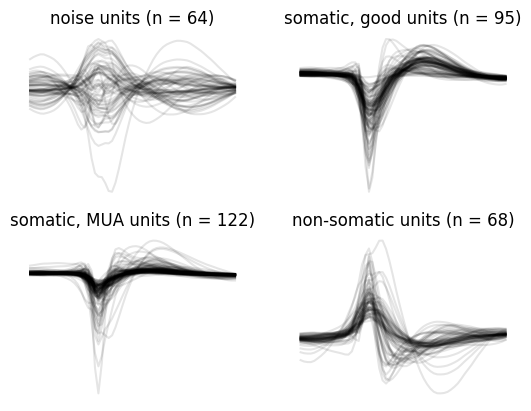

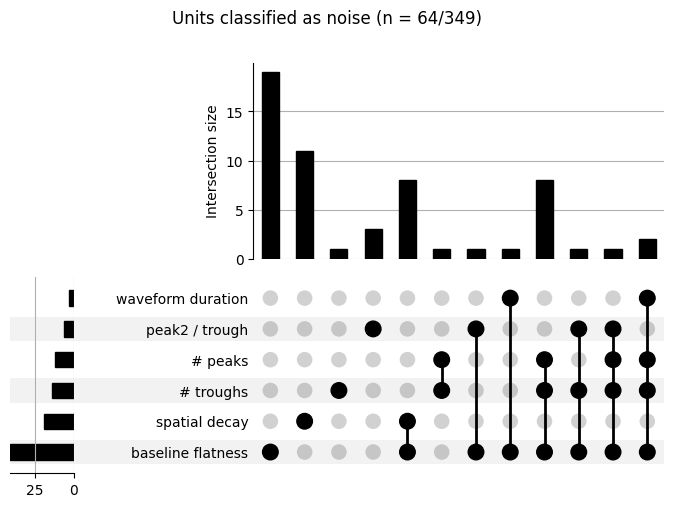

<Figure size 640x480 with 0 Axes>

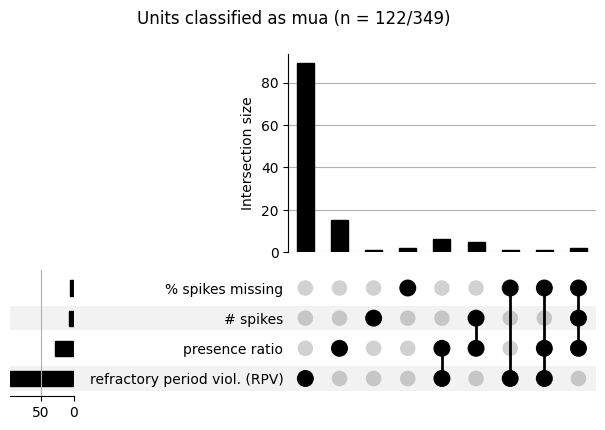

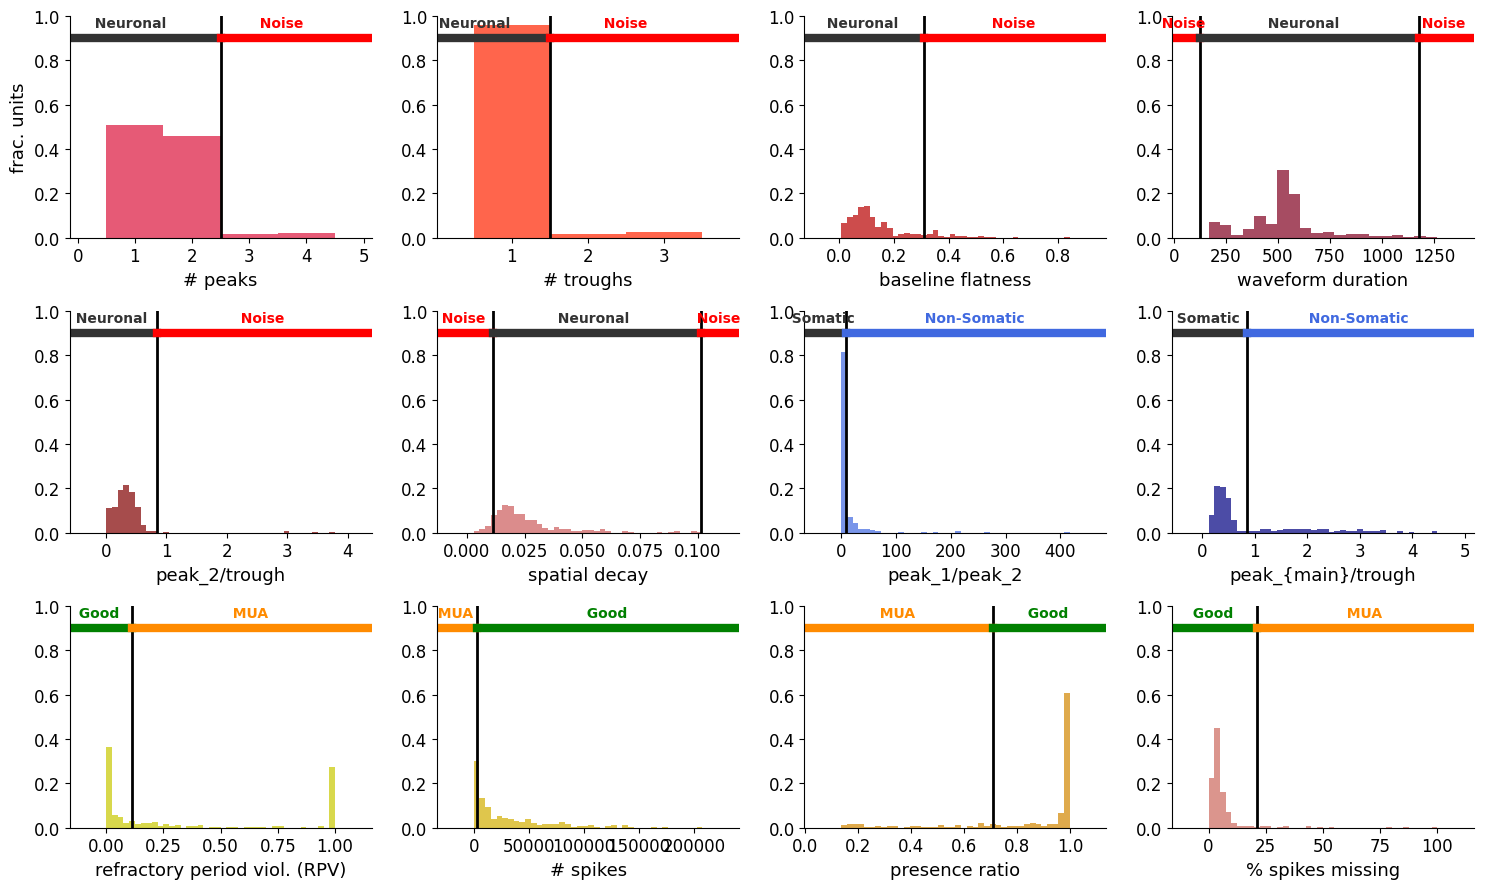


Saving results...
📁 Saving TSV files to Kilosort directory: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4
All expected metrics were successfully saved.


In [6]:
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, save_path, param
)
# Use the output summary plots (below) to see if the 
# quality metric thresholds seem roughly OK for your 
# data (i.e. there isn't one threshold removing all 
# units or a threshold may below that removes none)
# more details on these output plots in the wiki:
# https://github.com/Julie-Fabre/bombcell/wiki/Summary-output-plots

##### How to access bombcell's saved quality metrics
Looking at all quality metric values per unit: 

In [7]:
# quality metric values
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

ValueError: All arrays must be of the same length

In [ ]:
# boolean table, if quality metrics pass threshold given parameters
boolean_quality_metrics_table = bc.make_qm_table(
    quality_metrics, param, unit_type_string
)
boolean_quality_metrics_table

,unit_type,Original ID,# peaks,# troughs,waveform duration,baseline flatness,peak2 / trough,spatial decay,% spikes missing,presence ratio,# spikes,fraction RPVs,trough / peak2,peak1 / peak2
0,GOOD,0,False,False,False,False,False,False,False,False,False,False,False,False
1,NOISE,1,False,False,False,True,False,False,False,False,False,False,False,False
2,GOOD,2,False,False,False,False,False,False,False,False,False,False,False,False
3,GOOD,3,False,False,False,False,False,False,False,False,False,False,False,False
4,MUA,4,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,NON-SOMA,347,False,False,False,False,False,False,False,False,False,False,True,False
345,MUA,348,False,False,False,False,False,False,False,True,False,True,False,False
346,NOISE,349,False,False,False,False,False,True,False,False,False,False,False,False
347,NOISE,350,False,False,False,True,False,True,False,False,False,False,False,False


Example: get all quality metrics for unit 12

In [8]:
u = 12

units = quality_metrics_table.phy_clusterID
quality_metrics_table.loc[units == u, :]

NameError: name 'quality_metrics_table' is not defined

#### Look at your data and bombcell's metrics in the minimal GUI

In [ ]:
# Launch minimal GUI.
# Ideally, take a look at your units for a few datasets so you can get an idea of which 
# parameters will work best for your purposes. 
gui = bc.unit_quality_gui(
    ks_dir=ks_dir,
    quality_metrics=quality_metrics,
    unit_types=unit_type,
    param=param,
    save_path=save_path,
)

Loaded GUI data from: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\for_GUI\gui_data.pkl
🚀 Auto-loaded GUI data from: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\for_GUI\gui_data.pkl
GUI data loaded successfully!
   Data types available: ['peak_locations', 'trough_locations', 'peak_loc_for_duration', 'trough_loc_for_duration', 'peak_trough_labels', 'duration_lines', 'spatial_decay_fits', 'amplitude_fits', 'channel_arrangements', 'waveform_scaling', 'acg_data', 'per_bin_metrics']
   Peak/trough detection: 342 units
   Spatial decay fits: 342 units
   Amplitude fits: 341 units
Total units: 349
⚠️  Warning: Could not load manual classifications: 'unit_id'
📝 Initialized manual classification system (no previous classifications found)
🚀 Auto-advance enabled: will automatically go to next unit after classification


In [14]:
# Compare manual vs BombCell classifications (only requires save_path)
save_path = r'Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell'
bc.compare_manual_vs_bombcell(save_path)

📊 Comparing manual vs BombCell classifications from: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell
✅ Loaded BombCell results: 349 units
📂 Found manual classifications for 348 units
❌ Error: 'unit_id'
   Make sure you have run BombCell analysis first and saved results.


Total overlapping clusters: 347


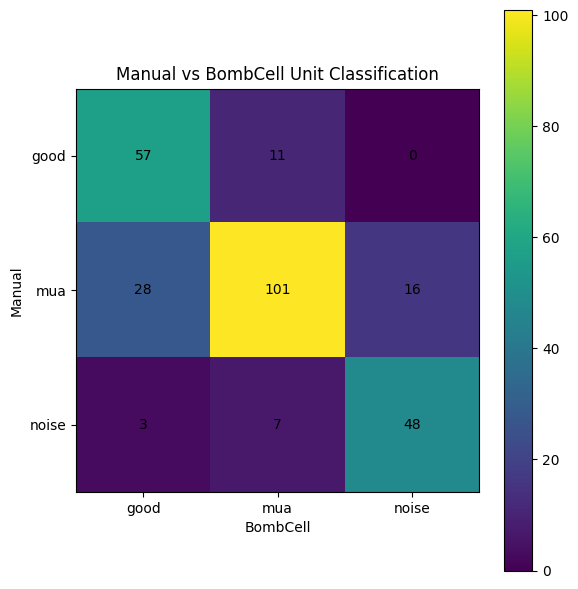


Overall agreement: 0.760

 good | precision: 0.648 | recall: 0.838
  mua | precision: 0.849 | recall: 0.697
noise | precision: 0.750 | recall: 0.828


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Paths (EDIT THESE)
# -----------------------------
bc_path = r"Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\cluster_bc_unitType.tsv"
manual_path = r"Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\manual_unit_classifications.tsv"


# -----------------------------
# Load TSV files
# -----------------------------
bc = pd.read_csv(bc_path, sep="\t")
manual = pd.read_csv(manual_path, sep="\t")

# -----------------------------
# Rename columns if needed
# -----------------------------
bc = bc.rename(columns={
    "cluster_id": "cluster_id",
    "bc_unitType": "bombcell_label"
})

manual = manual.rename(columns={
    "cluster_id": "cluster_id",
    "manual_label": "group"
})

# -----------------------------
# Merge on cluster_id
# -----------------------------
df = pd.merge(bc, manual, on="cluster_id", how="inner")
print(f"Total overlapping clusters: {len(df)}")

# -----------------------------
# Normalize labels
# -----------------------------
def normalize_label(x):
    x = str(x).lower()
    if x in ["good", "single", "unit"]:
        return "good"
    if x in ["mua", "multi"]:
        return "mua"
    if x in ["noise", "bad"]:
        return "noise"
    return "other"

df["bombcell_label"] = df["bombcell_label"].apply(normalize_label)
df["manual_label"] = df["group"].apply(normalize_label)

labels = ["good", "mua", "noise"]
label_to_idx = {l: i for i, l in enumerate(labels)}

# -----------------------------
# Build confusion matrix manually
# -----------------------------
cm = np.zeros((len(labels), len(labels)), dtype=int)

for _, row in df.iterrows():
    m = row["manual_label"]
    b = row["bombcell_label"]
    if m in label_to_idx and b in label_to_idx:
        cm[label_to_idx[m], label_to_idx[b]] += 1

# -----------------------------
# Plot confusion matrix
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("BombCell")
ax.set_ylabel("Manual")
ax.set_title("Manual vs BombCell Unit Classification")

# Annotate counts
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# -----------------------------
# Agreement statistics
# -----------------------------
total = cm.sum()
correct = np.trace(cm)
accuracy = correct / total if total > 0 else np.nan

print(f"\nOverall agreement: {accuracy:.3f}\n")

# Per-class precision / recall
for i, label in enumerate(labels):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    print(f"{label:>5} | precision: {precision:.3f} | recall: {recall:.3f}")



#### Fine-tune quality metric thresholds 
Based on bombcell's global output plots, looking through the GUI, your knowledge of neurons in your brain region and bombcell's suggestions above, you can adjust any of bombcell's quality metric thresholds and which quality metrics are computed.
For instance, if you are recording in the cerebellum and want to keep complex spikes, you might want to tweak waveform paramaters like max number of peaks and troughs to ensure you aren't classifying these units as noise. 

KeyError: np.int64(349)

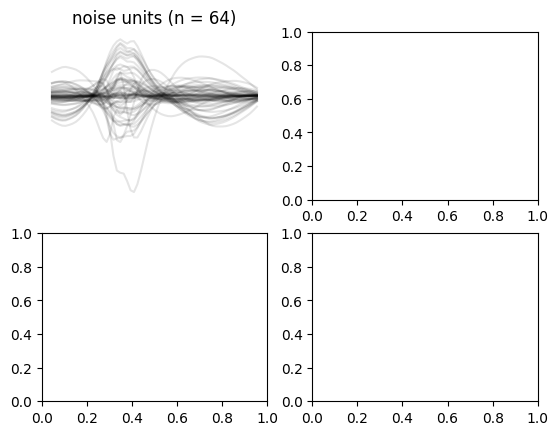

In [ ]:
# Example: how to tweak a classification threshold and replot the summary plots 

# load previously computed quality metrics
param, quality_metrics, fractions_RPVs_all_taur = bc.load_bc_results(save_path)
# change parameter of interest 
param["maxNPeaks"] = 3 # for instance, it you more atypical waveform shapes in your region of interest
# get quality unit types
unit_type, unit_type_string = bc.qm.get_quality_unit_type(
        param, quality_metrics
    ) 
# load ephys data
(
    spike_times_samples,
    spike_clusters, # actually spike_templates, but they're the same in bombcell
    template_waveforms,
    template_amplitudes,
    pc_features,
    pc_features_idx,
    channel_positions,
) = bc.load_ephys_data(ks_dir)
# replot global output plots
bc.plot_summary_data(quality_metrics, template_waveforms, unit_type, unit_type_string, param)


# Section 2: Ephys Properties & Cell Classification

In [12]:
# Use the real dataset for ephys properties demonstration
# ks_dir = "toy_data"
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4


In [13]:
# Compute ephys properties for cell type classification
ephys_param = bc.get_ephys_parameters(ks_dir)

# Compute all ephys properties - now defaults to ks_dir/bombcell
ephys_properties, ephys_param = bc.run_all_ephys_properties(ks_dir, ephys_param, save_path=save_path)

Computing ephys properties for 349 units ...


Computing ephys properties:   0%|          | 0/349 [00:00<?, ?it/s]

Ephys properties computation complete!
Ephys properties saved to: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\templates._bc_ephysProperties.parquet
Parameters saved to: Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4\bombcell\_bc_ephysParameters.parquet


Classifying striatum neurons...


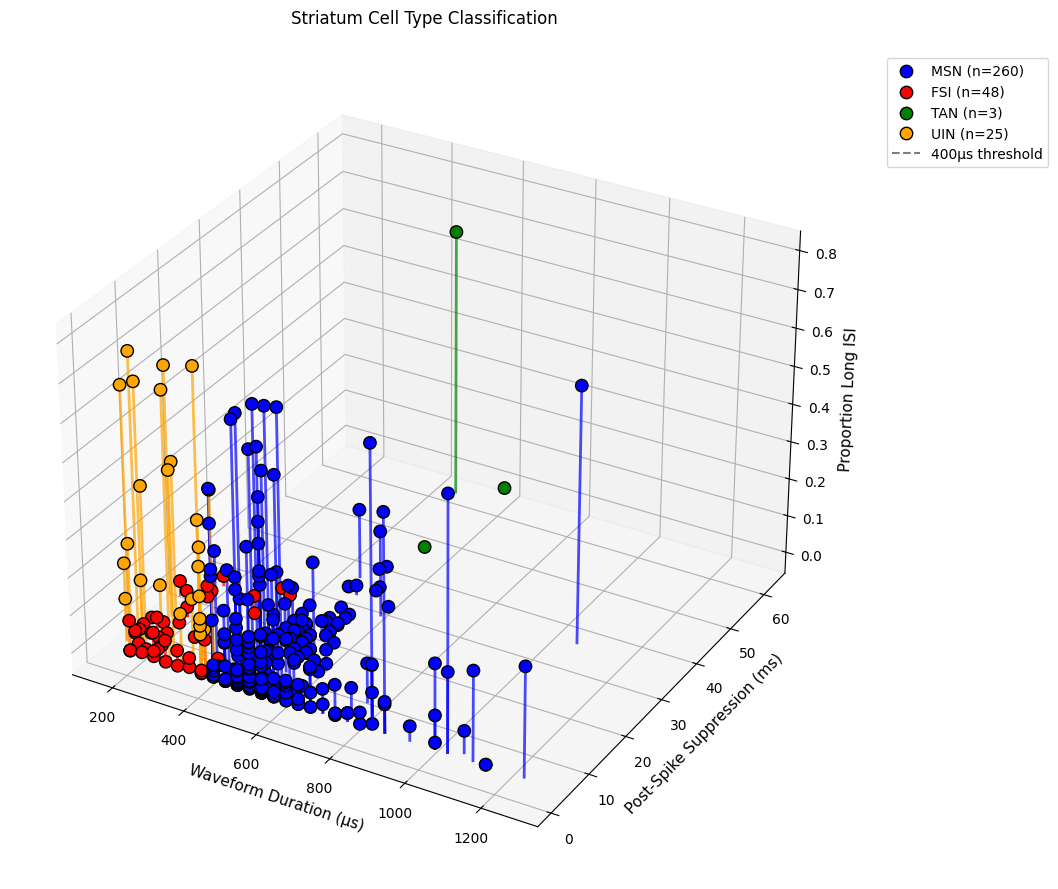

Plotted 336 units:
  Waveform duration range: 167-1267 μs
  Post-spike suppression range: 1.0-62.0 ms
  Prop long ISI range: 0.000-0.792

Striatum cell type distribution:
  MSN: 260 (74.5%)
  FSI: 48 (13.8%)
  TAN: 3 (0.9%)
  UIN: 25 (7.2%)
  Unknown: 13 (3.7%)


In [14]:
# Cell type classification with automatic plot generation
# Specify brain region: 'cortex' or 'striatum'
brain_region = 'striatum'  # Change this to 'cortex' for cortical data. Striatum and cortex are the only two options for now. 

print(f"Classifying {brain_region} neurons...")
cell_types = bc.classify_and_plot_brain_region(ephys_properties, ephys_param, brain_region)

In [14]:
# Show classification results
if cell_types is not None:
    # Create combined results table
    ephys_df = pd.DataFrame(ephys_properties)
    ephys_properties_table = ephys_df.copy()
    ephys_properties_table['cell_type'] = cell_types
   
    print(ephys_properties_table)

    unit_id  postSpikeSuppression  acg_tau_rise  acg_tau_decay    isi_cv  \
0         0              0.264976           3.0    3662.469531  4.265441   
1         1              2.790138           0.0      66.387905  4.797825   
2         2              0.562496           4.0            NaN  2.897528   
3         3              0.456108           1.0      11.905419  3.254744   
4         4              1.953192           0.0      57.631904  3.039968   
5         5              0.140160           4.0            NaN  5.296871   
6         6              0.009704          10.0            NaN  9.065419   
7         7              0.000000           2.0       3.966382  1.829375   
8         8              0.856894           3.0      53.264784  2.286946   
9         9                   NaN           NaN            NaN       NaN   
10       10              0.000000           1.0       4.479466  3.931697   
11       11              0.000000           8.0            NaN  3.275890   
12       12 